# Recomendador basado en interacciones
Consiste en recomendar contenido de otros usuarios similares.
#### Principales caracteristicas
- Solo se necesitan las interacciones de los usuarios
- Problemas de arranque en frio

Usaremos la libreria [Surprise](https://surprise.readthedocs.io/en/stable/index.html)

## Antes de comenzar... veamos el dataset
Uso del dataset de [MovieLens](https://grouplens.org/datasets/movielens/)

In [1]:
import pandas as pd

ratings = pd.read_csv('./dataset/ml-latest-small/ratings.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Paso 1** Carga de los datos

In [2]:
from surprise import Reader, Dataset

ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

#Escala de puntuaciones
reader = Reader(rating_scale=(1.0, 5.0))

# Carga de datos desde el data frame
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

**Paso 2**. Creación de un model colaborativo usando [knn](https://surprise.readthedocs.io/en/stable/knn_inspired.html)

In [3]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate

#knn
algo = KNNBasic()
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9489  0.9437  0.9453  0.9492  0.9477  0.9470  0.0021  
Fit time          0.25    0.29    0.33    0.19    0.19    0.25    0.05    
Test time         1.98    2.21    1.83    1.30    1.29    1.72    0.37    


{'test_rmse': array([0.94893398, 0.94370611, 0.9452659 , 0.9492055 , 0.94774118]),
 'fit_time': (0.24730873107910156,
  0.2899816036224365,
  0.32602453231811523,
  0.18798303604125977,
  0.19399785995483398),
 'test_time': (1.9845514297485352,
  2.2108538150787354,
  1.826352596282959,
  1.2985146045684814,
  1.2857615947723389)}

### Estimación del valor de *K*

In [4]:
import numpy as np
import matplotlib.pyplot as plt

kValues =[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


lstErrores = list()

for i in range(len(kValues)):
    print ("\n\n\n------------")
    print ("|   K = " + str(kValues[i])+"  |")
    print ("------------")
    
    algo = KNNBasic(k=kValues[i])
    estimacion = cross_validate(algo, data, measures=['RMSE'], cv=5)
    
    trainRes = np.average(estimacion['test_rmse'])
    print ("\nRESULATADO ENTRENAMIENTO: " + str(trainRes))
    
    lstErrores.append(trainRes)
    print ("--------------------------------")




------------
|   K = 10  |
------------
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

RESULATADO ENTRENAMIENTO: 0.9410788654917912
--------------------------------



------------
|   K = 20  |
------------
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

RESULATADO ENTRENAMIENTO: 0.9416395949486216
--------------------------------



------------
|   K = 30

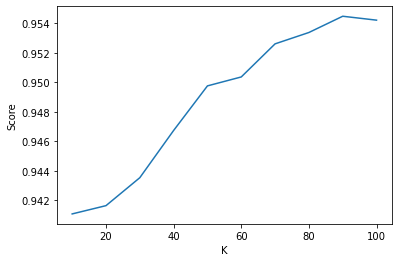

In [5]:
plt.plot(kValues,lstErrores)
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

## Entrenamiento del modelo

* Fijamos el valor de *K* según los errores obtenidos.
* Usamos todos los valores para entrenar

In [6]:
kFijado = 80

trainset = data.build_full_trainset()
knnTrain = KNNBasic(k=kFijado)
knnTrain.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


## Realizamos una recomendación con el modelo entrenado

Para datos ya conocidos

In [7]:
uid = 1  #Id del Usuario ¡¡IMPORTANTE!! el id debe existir
iid = 4  #Id del Contenido ¡¡IMPORTANTE!! el id debe existir

# Realizo una recomendación para el usuario y el contenido
pred = knnTrain.predict(uid, iid, r_ui=2, verbose=True)

user: 1          item: 4          r_ui = 2.00   est = 2.52   {'actual_k': 7, 'was_impossible': False}


## Recomendaciones para usuarios

Buscar para cada usuario los 10 mejores elementos a recomendar

**Paso 1**. Generamos precicciones para todos los pares de usuarios - contenidos que no están en el dataset de entrenameinto

In [8]:
testset = trainset.build_anti_testset()
predictions = knnTrain.test(testset)

**Paso 2**. Procesamos la predicción para obtener para cada usuario los *n* mejores elementos

In [9]:
from collections import defaultdict

#Codigo proporcionado en la web de Surprise
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

topUsuarios = get_top_n(predictions)


**Paso 3**. Obtener recomendación para usuarios

In [10]:
lstUsuariosRecomendar = [1,2,78]

for i in range(len(lstUsuariosRecomendar)):
    print ("Recomendación usuario " + str(lstUsuariosRecomendar[i]))
    print (topUsuarios[lstUsuariosRecomendar[i]] )
    print ("\n--------------------------------------------------\n\n")


Recomendación usuario 1
[(131724, 5.0), (5746, 5.0), (6835, 5.0), (3851, 5.0), (1151, 5.0), (1631, 5.0), (2075, 5.0), (176601, 5.0), (92494, 5.0), (102217, 5.0)]

--------------------------------------------------


Recomendación usuario 2
[(3851, 5.0), (5890, 5.0), (238, 5.0), (685, 5.0), (484, 5.0), (1105, 5.0), (1151, 5.0), (176601, 5.0), (92494, 5.0), (102217, 5.0)]

--------------------------------------------------


Recomendación usuario 78
[(131724, 5.0), (3851, 5.0), (1151, 5.0), (1631, 5.0), (1696, 5.0), (2075, 5.0), (176601, 5.0), (92494, 5.0), (102217, 5.0), (27523, 5.0)]

--------------------------------------------------


